# Autores: Kauan Mariani Ferreira, Pedro Henrique Coterli e Samuel Lima

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
import torch.optim as optim
from torch.optim import SGD
import os
import json
import math

import numpy as np
import zipfile
import shutil
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

## Dataset e preparação dos dados

In [ ]:
# Diretório dos dados
DATA_DIR = "./cifar10"

# Médias e desvios padrão do CIFAR-10
cifar10_mean = (0.4914, 0.4822, 0.4465)
cifar10_std = (0.2023, 0.1994, 0.2010)

# Carregando o dataset de treino
train_dataset_base = torchvision.datasets.CIFAR10(
    root = DATA_DIR,
    train = True,
    download = True,
    transform = None
)

# Transformação apenas para carregar os dados de teste
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(cifar10_mean, cifar10_std)
])

# Carregando o dataset de teste
test_dataset = torchvision.datasets.CIFAR10(
    root = DATA_DIR,
    train = False,
    download = True,
    transform = transform_test
)

print("Total de imagens de treino (base):", len(train_dataset_base))
print("Total de imagens de teste:", len(test_dataset))

In [ ]:
def get_ssl_indices(dataset_targets, n_labeled_per_class, n_classes = 10):
    """
    Divide os índices do dataset em "rotulados" e "não rotulados".

    Args:
        dataset_targets (list or np.array): Lista com todos os rótulos do dataset.
        n_labeled_per_class (int): Número de amostras rotuladas por classe.
        n_classes (int): Número total de classes.

    Returns:
        tuple: (labeled_indices, unlabeled_indices)
    """
    targets = np.array(dataset_targets)
    labeled_indices = []
    unlabeled_indices = []

    # Para cada classe...
    for i in range(n_classes):
        # Encontra todos os índices dessa classe
        indices_current_class = np.where(targets == i)[0]
        # Embaralha esses índices
        np.random.shuffle(indices_current_class)
        # Adiciona os N primeiros aos índices rotulados
        labeled_indices.extend(indices_current_class[:n_labeled_per_class])
        # Adiciona o restante aos índices não rotulados
        unlabeled_indices.extend(indices_current_class[n_labeled_per_class:])

    # Embaralha o resultado final (as classes estavam todas juntas)
    np.random.shuffle(labeled_indices)
    np.random.shuffle(unlabeled_indices)

    print("Total de índices rotulados:", len(labeled_indices))
    print("Total de índices não rotulados:", len(unlabeled_indices))

    return labeled_indices, unlabeled_indices

In [ ]:
# Número de dados rotulados por classe no conjunto de treino
LABELS_PER_CLASS = 25

# Pegando todos os alvos do dataset
all_targets = train_dataset_base.targets

# Gerando os índices rotulados e não rotulados
labeled_indices, unlabeled_indices = get_ssl_indices(all_targets, LABELS_PER_CLASS)

## Transformações

In [ ]:
# Transformação fraca para os dados rotulados
# e para gerar pseudo-labels nos dados não rotulados
transform_weak = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(size = 32,
                          padding = 4,
                          padding_mode = "reflect"),
    transforms.ToTensor(),
    transforms.Normalize(cifar10_mean, cifar10_std)
])

# Transformação forte para a consistency regularization
transform_strong = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(size = 32,
                          padding = 4,
                          padding_mode = "reflect"),
    transforms.RandAugment(num_ops = 2, magnitude = 10),
    transforms.ToTensor(),
    transforms.RandomErasing(p=1.0, scale=(0.125, 0.125), ratio=(1, 1), value='random'),
    transforms.Normalize(cifar10_mean, cifar10_std)
])

## Datasets customizados

In [ ]:
# Dataset rotulado
class CIFAR10Labeled(Dataset):
    def __init__(self, base_dataset, indices, transform):
        """
        Args:
            base_dataset = Dataset CIFAR-10 original.
            indices (list): Lista dos índices que compõem o dataset rotulado.
            transform: Pipeline de transformação fraca.
        """
        self.base_dataset = base_dataset
        self.indices = indices
        self.transform = transform

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        # Pegando o índice real do dataset base
        real_idx = self.indices[idx]
        # Obtendo a imagem e o label
        img, target = self.base_dataset[real_idx]
        # Aplicando a transformação fraca
        img_transformed = self.transform(img)

        return img_transformed, target


# Dataset não rotulado
class CIFAR10Unlabeled(Dataset):
    def __init__(self, base_dataset, indices, transform_weak, transform_strong):
        """
        Args:
            base_dataset = Dataset CIFAR-10 original.
            indices (list): Lista dos índices que compõem o dataset rotulado.
            transform_weak: Pipeline de transformação fraca.
            transform_strong: Pipeline de transformação forte.
        """
        self.base_dataset = base_dataset
        self.indices = indices
        self.transform_weak = transform_weak
        self.transform_strong = transform_strong

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        # Pegando o índice real do dataset base
        real_idx = self.indices[idx]
        # Obtendo a imagem e ignorando o label
        img, _ = self.base_dataset[real_idx]
        # Aplicando as transformações
        img_weak_transformed = self.transform_weak(img)
        img_strong_transformed = self.transform_strong(img)

        return img_weak_transformed, img_strong_transformed

In [ ]:
# Criando os datasets
labeled_dataset = CIFAR10Labeled(train_dataset_base, labeled_indices, transform_weak)
unlabeled_dataset = CIFAR10Unlabeled(train_dataset_base, unlabeled_indices, transform_weak, transform_strong)

BATCH_SIZE = 64
# Batch size de dados rotulados
LABELED_BATCH_SIZE = BATCH_SIZE
# Batch size de dados não rotulados (maior que o para dados rotulados)
UNLABELED_BATCH_SIZE = LABELED_BATCH_SIZE * 7

# Criando os dataloaders
labeled_loader = DataLoader(
    labeled_dataset,
    batch_size = LABELED_BATCH_SIZE,
    shuffle = True,
    num_workers = 4,
    drop_last = True
)

unlabeled_loader = DataLoader(
    unlabeled_dataset,
    batch_size = UNLABELED_BATCH_SIZE,
    shuffle = True,
    num_workers = 4,
    drop_last = True
)

test_loader = DataLoader(
    test_dataset,
    batch_size = BATCH_SIZE,
    shuffle = False,
    num_workers = 4
)

print("Tamanho do labeled dataset:", len(labeled_dataset))
print("Tamanho do unlabeled dataset:", len(unlabeled_dataset))
print("Tamanho do test dataset:", len(test_dataset))
print("Batches rotulados por época:", len(labeled_loader))
print("Batches não rotulados por época:", len(unlabeled_loader))

## Modelo base

In [ ]:
# Bloco residual básico
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride = 1):
        super(BasicBlock, self).__init__()

        # Primeira convolução 3x3
        self.conv1 = nn.Conv2d(
            in_channels, out_channels, kernel_size = 3, stride = stride, padding = 1, bias = False
        )
        self.bn1 = nn.BatchNorm2d(out_channels)

        # Segunda convolução 3x3
        self.conv2 = nn.Conv2d(
            out_channels, out_channels, kernel_size = 3, stride = 1, padding = 1, bias = False
        )
        self.bn2 = nn.BatchNorm2d(out_channels)

        # Camada de atalho para a conexão residual
        # Corrige o shape da entrada se não for possível fazer a soma com a saída
        self.shortcut = nn.Sequential()

        if stride != 1 or in_channels != self.expansion * out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, self.expansion * out_channels,
                          kernel_size = 1, stride = stride, bias = False),
                nn.BatchNorm2d(self.expansion * out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        # Soma residual
        out += self.shortcut(x)
        out = F.relu(out)

        return out

In [ ]:
# Arquitetura ResNet
class ResNet(nn.Module):
    def __init__(self, block = BasicBlock, num_classes = 10):
        super(ResNet, self).__init__()
        self.in_channels = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size = 3,
                               stride = 1, padding = 1, bias = False)
        self.bn1 = nn.BatchNorm2d(64)

        # Camadas residuais
        self.layer1 = self._make_layer(block, 64, 2, stride = 1)
        self.layer2 = self._make_layer(block, 128, 2, stride = 2)
        self.layer3 = self._make_layer(block, 256, 2, stride = 2)
        self.layer4 = self._make_layer(block, 512, 2, stride = 2)

        # Pooling final
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

        # FC classificador
        self.linear = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []

        for each_stride in strides:
            layers.append(block(self.in_channels, out_channels, each_stride))
            self.in_channels = out_channels * block.expansion

        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avgpool(out)
        # Flatten
        out = out.view(out.size(0), -1)
        out = self.linear(out)

        return out

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Usando dispositivo:", device)

model = ResNet().to(device)

## Loss function

In [ ]:
# Peso da perda não supervisionada
LAMBDA_UNSUPERVISED = 1.0
# Threshold de confiança (tau)
THRESHOLD = 0.95

In [ ]:
class EMA:
    """
    Exponential moving average para ter mais estabilidade na média do teste.
    """
    def __init__(self, model, decay):
        self.decay = decay
        self.shadow = {}
        for name, param in model.named_parameters():
            if param.requires_grad:
                self.shadow[name] = param.clone().detach()

    # Chamando a função
    def __call__(self, model):
        with torch.no_grad():
            for name, param in model.named_parameters():
                if param.requires_grad:
                    new_average = (1.0 - self.decay) * param + self.decay * self.shadow[name]
                    self.shadow[name] = new_average

    # Coloca os pesos do modelo como a média
    def assign(self, model):
        self.original = {}
        for name, param in model.named_parameters():
            if param.requires_grad:
                self.original[name] = param.clone()
                param.data.copy_(self.shadow[name].data)

    # Volta os pesos do modelo
    def resume(self, model):
        for name, param in model.named_parameters():
            if param.requires_grad:
                param.data.copy_(self.original[name].data)

O paper original introduz o decaimento da LR por cosseno, implmeentamos do mesmo modo.

In [ ]:
def cosine_lr_decay(k: int, total_steps: int):
    """Função de decaimento cosseno"""
    return max(0.0, math.cos(math.pi * 7 * k / (16 * total_steps)))

In [ ]:
def fixmatch_loss(criterion_supervised,
                  criterion_unsupervised,
                  logits_supervised,
                  targets_supervised,
                  logits_unsupervised_weak,
                  logits_unsupervised_strong):
    """
    Calcula a perda do FixMatch.

    Args:
        criterion_supervised: Critério para a perda supervisionada.
        criterion_unsupervised: Critério para a perda não supervisionada.
        logits_supervised (Tensor): Saída do modelo para o batch rotulado.
        targets_supervised (Tensor): Rótulos verdadeiros para o batch rotulado.
        logits_unsupervised_weak (Tensor): Saída do modelo para o batch não rotulado com weak augmentation.
        logits_unsupervised_strong (Tensor): Saída do modelo para o batch não rotulado com strong augmentation.

    Returns:
        tuple: (
            total_loss (Tensor): Perda total.
            loss_supervised (Tensor): Perda supervisionada.
            loss_unsupervised (Tensor): Perda não supervisionada.
            percent_confident (Tensor): Percentual de amostras não rotuladas que passaram no limiar de confiança.
        )
    """

    # Loss supervisionada
    loss_supervised = criterion_supervised(logits_supervised, targets_supervised)

    # Loss não supervisionada
    with torch.no_grad():
        # Obtendo as probabilidades e pseudo-labels da weak augmentation
        probs_unsupervised_weak = F.softmax(logits_unsupervised_weak, dim = 1)
        # Encontrando a confiança e os pseudo-labels
        max_prob, pseudo_label = torch.max(probs_unsupervised_weak, dim = 1)
        # Máscara de confiança
        mask = max_prob.ge(THRESHOLD).float()

    # Consistency loss
    loss_unsupervised_per_sample = criterion_unsupervised(logits_unsupervised_strong, pseudo_label)
    # Aplicando a máscara
    masked_loss_unsupervised = loss_unsupervised_per_sample * mask

    # Tirando a média
    num_confident_samples = mask.sum()

    loss_unsupervised = masked_loss_unsupervised.mean()

    # Percentual confiável do batch
    percent_confident = mask.mean()

    # Loss total
    total_loss = loss_supervised + LAMBDA_UNSUPERVISED * loss_unsupervised

    return total_loss, loss_supervised, loss_unsupervised, percent_confident

## Treinamento

In [ ]:
def evaluate(model, test_loader, device, ema_model=None):
    """
    Calcula a acurácia do modelo no conjunto de teste.
    """
    if ema_model is not None:
        ema_model.assign(model)

    model.eval()
    correct, total = 0, 0

    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            logits = model(inputs)
            preds = logits.argmax(dim=1)
            correct += (preds == targets).sum().item()
            total += targets.size(0)

    acc = correct / total

    if ema_model is not None:
        ema_model.resume(model)

    model.train()
    return acc


## Funções auxiliares

In [ ]:
def cycle(loader):
    """Iterador que cicla o DataLoader indefinidamente."""
    while True:
        for data in loader:
            yield data

def _save_checkpoint(model, optimizer, scheduler, ema_model, history, epoch, best_acc, latest_checkpoint_path):
    """Salva o estado do treinamento e o melhor estado."""
    state = {
        "epoch": epoch + 1,
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "scheduler_state_dict": scheduler.state_dict(),
        "ema_model_shadow": ema_model.shadow,
        "history": history,
        "best_acc": best_acc
    }
    torch.save(state, latest_checkpoint_path)
    print(f"Estado mais recente salvo (época {epoch + 1}) em: {latest_checkpoint_path}")

In [ ]:
def _setup_experiment(base_name, num_labeled_samples, save_root, model, ema_decay, pretrained_tag = False):
    """Configura o nome do experimento, diretórios e inicializa o EMA."""
    if num_labeled_samples is not None:
        if pretrained_tag:
            experiment_name = f"{base_name}_{num_labeled_samples}samples_pretrained"
        else:
            experiment_name = f"{base_name}_{num_labeled_samples}samples"
    else:
        experiment_name = base_name

    save_dir = os.path.join(save_root, experiment_name)
    os.makedirs(save_dir, exist_ok=True)
    latest_checkpoint_path = os.path.join(save_dir, "latest_state.pth")

    ema_model = EMA(model, ema_decay)

    print(f"--- Iniciando experimento: {experiment_name} ---")
    print(f"Checkpoints serão salvos em: {save_dir}")

    return experiment_name, save_dir, latest_checkpoint_path, ema_model

def _load_checkpoint(latest_checkpoint_path, model, optimizer, scheduler, ema_model, device):
    """
    Carrega os modelos de um checkpoint
    """
    start_epoch = 0
    best_acc = 0.0
    history = {
        "loss": [], "loss_supervised": [], "loss_unsupervised": [],
        "confidence": [], "test_accuracy": []
    }

    if os.path.exists(latest_checkpoint_path):
        checkpoint = torch.load(latest_checkpoint_path, map_location=device, weights_only=False)
        model.load_state_dict(checkpoint["model_state_dict"])
        optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
        scheduler.load_state_dict(checkpoint["scheduler_state_dict"])

        if "ema_model_shadow" in checkpoint:
            ema_model.shadow = checkpoint["ema_model_shadow"]


        history = checkpoint.get("history", history)
        start_epoch = checkpoint["epoch"]
        best_acc = checkpoint.get("best_acc", 0.0)
        print(f"Checkpoint encontrado: retomando de {latest_checkpoint_path} (época {start_epoch})\n")

    return start_epoch, best_acc, history


def _train_step(model, optimizer, scheduler, ema_model, labeled_iter, unlabeled_iter, criterion_supervised, criterion_unsupervised, device):
    """Executa um único passo de treinamento do FixMatch e realiza as inferências.
    """
    # Preparação dos Dados
    inputs_supervised, targets_supervised = next(labeled_iter)
    inputs_unsupervised_weak, inputs_unsupervised_strong = next(unlabeled_iter)

    inputs_supervised = inputs_supervised.to(device)
    targets_supervised = targets_supervised.to(device)
    inputs_unsupervised_weak = inputs_unsupervised_weak.to(device)
    inputs_unsupervised_strong = inputs_unsupervised_strong.to(device)

    logits_supervised = model(inputs_supervised)

    with torch.no_grad():
        logits_unsupervised_weak = model(inputs_unsupervised_weak)

    logits_unsupervised_strong = model(inputs_unsupervised_strong)

    total_loss, loss_supervised, loss_unsupervised, conf_percent = fixmatch_loss(
        criterion_supervised, criterion_unsupervised,
        logits_supervised, targets_supervised,
        logits_unsupervised_weak, logits_unsupervised_strong
)

    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    scheduler.step()

    ema_model(model)
    return total_loss.item(), loss_supervised.item(), loss_unsupervised.item(), conf_percent.item()

In [ ]:
def train_fixmatch(model, labeled_loader, unlabeled_loader, test_loader, optimizer, scheduler,
                   epochs, steps_per_epoch, device, num_labeled_samples=None,
                   base_name="FixMatch", save_root="experiments", ema_decay=0.999, pretrained_tag = False):
    """
    Executa o loop de treinamento do FixMatch e.
    """
    # Inicializa
    experiment_name, save_dir, latest_checkpoint_path, ema_model = _setup_experiment(
        base_name, num_labeled_samples, save_root, model, ema_decay, pretrained_tag
    )

    # Carrega     o checkpoint
    start_epoch, best_acc, history = _load_checkpoint(
        latest_checkpoint_path, model, optimizer, scheduler, ema_model, device
    )

    if start_epoch > 0:
        ema_model.assign(model)

    model.train()
    criterion_supervised = nn.CrossEntropyLoss().to(device)
    criterion_unsupervised = nn.CrossEntropyLoss(reduction="none").to(device)

    labeled_iter = cycle(labeled_loader)
    unlabeled_iter = cycle(unlabeled_loader)

    print(f"Treinando por {epochs} épocas, {steps_per_epoch} passos/época\n")

    # loop do treinamento
    for epoch in range(start_epoch, epochs):
        epoch_loss, epoch_loss_supervised, epoch_loss_unsupervised, epoch_confidence = [], [], [], []

        pbar = tqdm(range(steps_per_epoch),
                    desc=f"[] Época {epoch + 1}/{epochs}",
                    ncols=100, mininterval=2)

        for step in pbar:
            # Treinamento do Passo
            total_loss, loss_sup, loss_unsup, conf_percent = _train_step(
                model, optimizer, scheduler, ema_model, labeled_iter, unlabeled_iter,
                criterion_supervised, criterion_unsupervised, device
            )

            epoch_loss.append(total_loss)
            epoch_loss_supervised.append(loss_sup)
            epoch_loss_unsupervised.append(loss_unsup)
            epoch_confidence.append(conf_percent)
            # print(np.mean(epoch_loss))
            pbar.set_postfix(
                Loss=np.mean(epoch_loss),
                Conf=f"{np.mean(epoch_confidence) * 100:.1f}%"
            )

        # Avaliando no teste e avaliando o hisórico
        test_accuracy = evaluate(model, test_loader, device, ema_model)

        history["loss"].append(np.mean(epoch_loss))
        history["loss_supervised"].append(np.mean(epoch_loss_supervised))
        history["loss_unsupervised"].append(np.mean(epoch_loss_unsupervised))
        history["confidence"].append(np.mean(epoch_confidence))
        history["test_accuracy"].append(test_accuracy)

        # Atualiza a melhor acurácia
        if test_accuracy > best_acc:
            best_acc = test_accuracy

        print(f"\nFim da época {epoch + 1}: "
              f"Acurácia no teste: {test_accuracy:.2f} | "
              f"Loss total média: {np.mean(epoch_loss):.4f}")


        _save_checkpoint(model, optimizer, scheduler, ema_model, history, epoch, best_acc, latest_checkpoint_path)
        history_path = os.path.join(save_dir, f"{experiment_name}_history.json")
        with open(history_path, "w") as f:
            json.dump(history, f, indent=4)

    history_path = os.path.join(save_dir, f"{experiment_name}_history.json")
    with open(history_path, "w") as f:
        json.dump(history, f, indent=4)
    print(f"\nHistórico salvo em: {history_path}")

    print(f"--- Experimento {experiment_name} concluído ---")
    print(f"Acurácia final no teste: {history['test_accuracy'][-1]:.2f}")
    print(f"Melhor acurácia: {best_acc:.2f}")

    return history

## Função que define o experimento

In [ ]:
def run_experiment_fixmatch(model_class, labels_per_class, epochs=20, steps_per_epoch=512, lr=0.03, weight_decay=0.0005,
    momentum=0.9, base_name="FixMatch", save_root="experiments", device=device, pretrained_tag = False
):
    """
    Configura e executa um experimento FixMatch completo.
    """
    print(f"=== Iniciando experimento {base_name} com {labels_per_class} rótulos/classe ===")

    labeled_indices, unlabeled_indices = get_ssl_indices(all_targets, labels_per_class)

    # Datasets
    labeled_dataset = CIFAR10Labeled(train_dataset_base, labeled_indices, transform_weak)
    unlabeled_dataset = CIFAR10Unlabeled(train_dataset_base, unlabeled_indices, transform_weak, transform_strong)

    labeled_loader = DataLoader(labeled_dataset, batch_size=LABELED_BATCH_SIZE, shuffle=True, num_workers=0, drop_last=False)
    unlabeled_loader = DataLoader(unlabeled_dataset, batch_size=UNLABELED_BATCH_SIZE, shuffle=True, num_workers=0, drop_last=True)

    # Modelo
    model = model_class().to(device)
    model.train()

    # Separação de parâmetros não pode aplicar em bn
    bn_params, other_params = [], []
    for name, param in model.named_parameters():
        if 'bn' in name:
            bn_params.append(param)
        else:
            other_params.append(param)

    # Otimizador e scheduler
    optimizer = SGD(
        [{'params': other_params}, {'params': bn_params, 'weight_decay': 0}],
        lr=lr,
        momentum=momentum,
        weight_decay=weight_decay,
        nesterov=True
    )

    total_steps = epochs * steps_per_epoch
    scheduler = optim.lr_scheduler.LambdaLR(optimizer, lambda x: cosine_lr_decay(x, total_steps))

    history = train_fixmatch(
        model=model,
        labeled_loader=labeled_loader,
        unlabeled_loader=unlabeled_loader,
        test_loader=test_loader,
        optimizer=optimizer,
        scheduler=scheduler,
        epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        device=device,
        num_labeled_samples=labels_per_class,
        base_name=base_name,
        save_root=save_root,
        pretrained_tag = pretrained_tag
    )

    return history, model, test_loader


## Experimentos:
### 1 rótulos

In [ ]:
history_1label, model_1_label, test_loader = run_experiment_fixmatch(ResNet, labels_per_class=1)

### 4 rótulos

In [ ]:
history_4label, model_4_label, test_loader = run_experiment_fixmatch(ResNet, labels_per_class=4)

### 25 rótulos

In [ ]:
history_25label, model_25_label, test_loader = run_experiment_fixmatch(ResNet, labels_per_class=25)

### 400 rótulos

In [ ]:
history_400label, model_400_label, test_loader = run_experiment_fixmatch(ResNet, labels_per_class=400)

### Carregando o modelo pré-treinado
Utilizamos até agora uma resnet treinada do 0, mas se carregarmos um modelo que já tem os pesos treinados, acreditamos que o modelo performará melhor. Assim defniremos uma nova classe que adaptada uma resnet treinada com o imagenet para o nosso modelo e treinaremos com 400 labels.

In [ ]:
import torchvision.models as models

class ResNetPretreined(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        # Carrega pré treinado
        self.model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

        # Adapta a primeira camada para CIFAR-10 (imagens 32x32)
        self.model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.model.maxpool = nn.Identity()  # Remove maxpool (desnecessário p/ CIFAR)

        # Troca o classificador final
        in_features = self.model.fc.in_features
        self.model.fc = nn.Linear(in_features, num_classes)

    def forward(self, x):
        return self.model(x)


In [ ]:
history_resnet_pretrained_25, model_resnet_pretrained, test_loader = run_experiment_fixmatch(ResNetPretreined, labels_per_class=25, pretrained_tag = True)

## Análises

In [4]:
if not os.path.exists("fixmatch_results"):
    !gdown "1a79Dq7Z7uM4I3ygpv5HunEm8AK7nYzb5" -O "history.zip"

    # Cria a pasta
    os.makedirs("fixmatch_results", exist_ok=True)

    with zipfile.ZipFile("history.zip", "r") as zip_ref:
        zip_ref.extractall("fixmatch_results")
   
    # Remove o zip
    os.remove("history.zip")

    print("JSONs extraídos com sucesso em 'fixmatch_results/'")

else:
    print("Pasta 'fixmatch_results' já existe.")

JSONs extraídos com sucesso em 'fixmatch_results/'


Downloading...
From: https://drive.google.com/uc?id=1a79Dq7Z7uM4I3ygpv5HunEm8AK7nYzb5
To: c:\Users\kauan\OneDrive - Fundacao Getulio Vargas - FGV\FGV\Matérias\6° Semestre\Deep Learning\fixmatch_implementation\history.zip

  0%|          | 0.00/7.12k [00:00<?, ?B/s]
100%|██████████| 7.12k/7.12k [00:00<?, ?B/s]


Carregando os jsons

In [ ]:
experiments = {
    "1 rótulo/classe": "/kaggle/working/fixmatch_results/FixMatch_1samples_history.json",
    "4 rótulos/classe": "/kaggle/working/fixmatch_results/FixMatch_4samples_history.json",
    "25 rótulos/classe": "/kaggle/working/fixmatch_results/FixMatch_25samples_history.json",
    "400 rótulos/classe": "/kaggle/working/fixmatch_results/FixMatch_400samples_history.json",
    "25 rótulos/classe pretrained": "/kaggle/working/fixmatch_results/FixMatch_25samples_pretrained_history.json",
    "400 rótulos/classe pretrained": "/kaggle/working/fixmatch_results/FixMatch_400samples_pretrained_history.json",
}

all_histories = {}

for label_setting, path in experiments.items():
    with open(path, "r") as f:
        all_histories[label_setting] = json.load(f)


### Plotando as acurácias

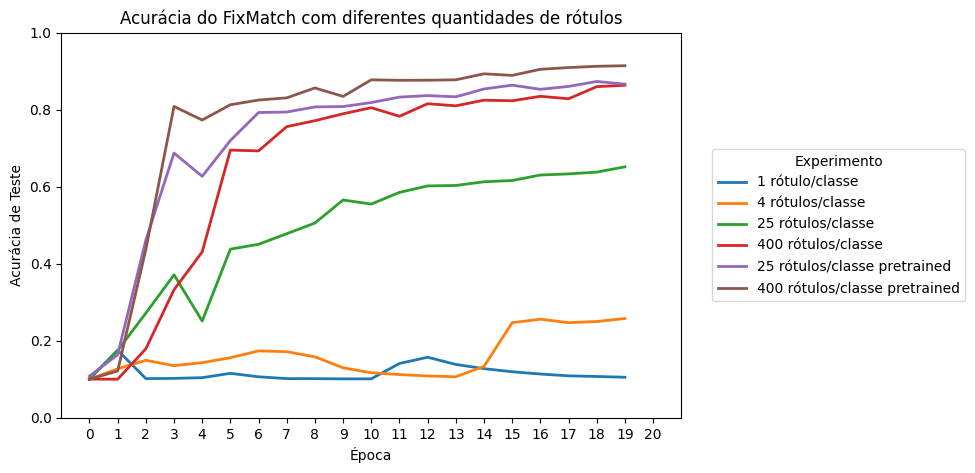

In [7]:
plt.figure(figsize=(8, 5))
for name, hist in all_histories.items():
    plt.plot(hist["test_accuracy"], label=name, linewidth=2)
plt.xlabel("Época")
plt.ylabel("Acurácia de Teste")
plt.title("Acurácia do FixMatch com diferentes quantidades de rótulos")
plt.legend(
    title="Experimento",
    bbox_to_anchor=(1.05, 0.5),
    loc="center left",
    borderaxespad=0.
)
plt.grid(False)
plt.ylim(0,1)
plt.xlim(-1,21)
plt.xticks(np.arange(0,21))
plt.show()


O gráfico de acurácia mostra claramente o impacto da quantidade de rótulos no desempenho do FixMatch. Com apenas 1 ou 4 rótulos por classe, o modelo praticamente não aprende, mantendo acurácia próxima a 10%, o que indica que as pseudo-labels geradas nesses cenários eram pouco confiáveis. Quando o número de rótulos aumenta para 25 por classe, há uma melhora expressiva de 65%, revelando que o FixMatch começa a se beneficiar da pseudo-rotulagem. Com 400 rótulos por classe, a acurácia chega a 86%, que é comparável ao desempenho do modelo com 25 rótulos pré-treinados, enquanto o com 400 rótulos pré-treinados supera ainda mais, obtendo 91% de acurácia, evidenciando o ganho obtido com representações previamente aprendidas.

### Comparação das losses

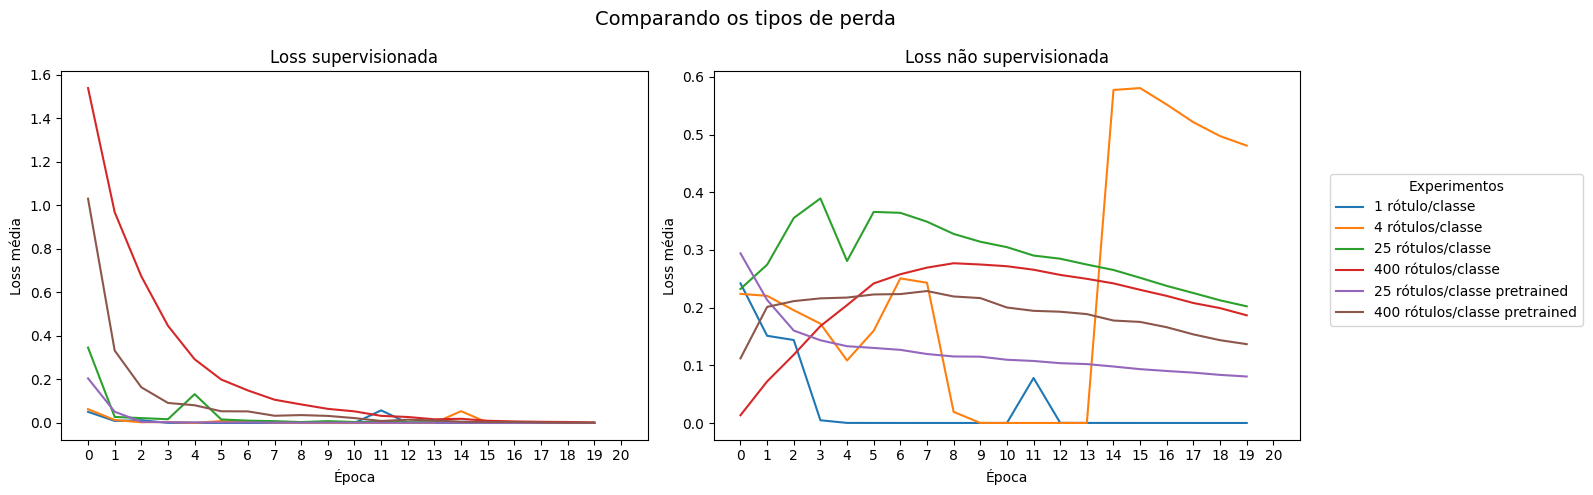

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

handles = []
labels = []

for name, hist in all_histories.items():
    line1, = ax[0].plot(hist["loss_supervised"], label=name)
    ax[1].plot(hist["loss_unsupervised"], color=line1.get_color())  # mesma cor

    handles.append(line1)
    labels.append(name)

ax[0].set_title("Loss supervisionada")
ax[1].set_title("Loss não supervisionada")

for a in ax:
    a.set_xlabel("Época")
    a.set_ylabel("Loss média")
    a.grid(False)
    a.set_xlim(-1, 21)
    a.set_xticks(np.arange(0, 21))

fig.legend(handles, labels, title="Experimentos",
           loc="center left", bbox_to_anchor=(0.89, 0.5),
           borderaxespad=0.)

plt.suptitle("Comparando os tipos de perda", fontsize=14)
plt.tight_layout(rect=[0, 0, 0.88, 1])
plt.show()


Na perda supervisionada, todos os experimentos convergem rapidamente, mostrando que o modelo consegue aprender bem com as amostras rotuladas, mesmo em quantidades reduzidas. Os cenários com mais rótulos apresentam perdas iniciais maiores, mas elas decaem rapidamente, estabilizando próximas de zero. Já a perda não supervisionada é mais instável, especialmente nos experimentos com poucos rótulos, refletindo a dificuldade do modelo em gerar pseudo-rótulos corretos no início do treinamento. Nos experimentos com pré-treinamento, essa perda apresenta comportamento mais suave e consistente, indicando que o modelo produz pseudo-labels mais confiáveis e aprende de forma mais estável.

 ### Evolução da confidence

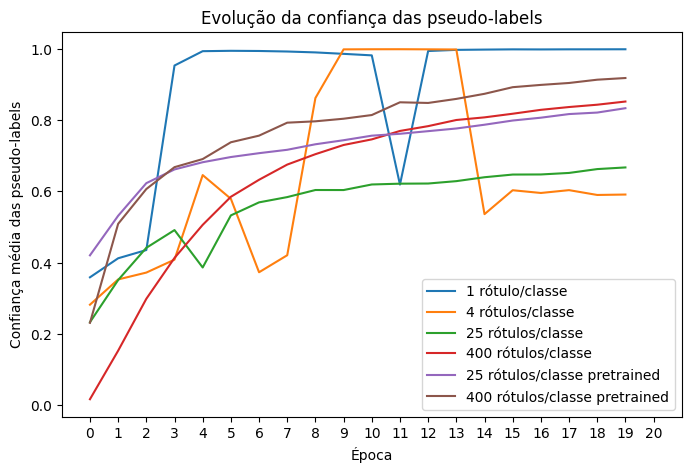

In [9]:
plt.figure(figsize=(8,5))
for name, hist in all_histories.items():
    plt.plot(hist["confidence"], label=name)
plt.xlabel("Época")
plt.ylabel("Confiança média das pseudo-labels")
plt.title("Evolução da confiança das pseudo-labels")
plt.legend()
plt.grid(False)
plt.xlim(-1,21)
plt.xticks(np.arange(0,21))
plt.show()

O gráfico de confiança mostra que os modelos com 1 e 4 rótulos por classe atingem rapidamente valores próximos de 1.0, mas essa confiança é ilusória, pois o modelo se torna superconfiante em pseudo-labels incorretos. Em contrapartida, os cenários com 25 e 400 rótulos apresentam um crescimento mais gradual da confiança, refletindo aprendizado mais equilibrado. Nos experimentos com pré-treinamento, a confiança inicial já é mais alta e continua aumentando de forma consistente, o que sugere que as representações aprendidas previamente ajudam o modelo a gerar pseudo-rótulos mais precisos desde as primeiras épocas.

### Comparação das losses

In [10]:
final_results = {
    name: hist["test_accuracy"][-1] for name, hist in all_histories.items()
}
pd.DataFrame.from_dict(final_results, orient="index", columns=["Acurácia final (%)"]) * 100


,Acurácia final (%)
1 rótulo/classe,10.51
4 rótulos/classe,25.77
25 rótulos/classe,65.16
400 rótulos/classe,86.35
25 rótulos/classe pretrained,86.64
400 rótulos/classe pretrained,91.43


A tabela de acurácia final confirma a forte dependência do FixMatch em relação à quantidade de dados rotulados e à qualidade das representações, além de mostrar que o pré-treinamento melhora ainda mais os resultados.
